# Import python packages

In [60]:
import pickle
import numpy as np
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, Reshape, Flatten
from keras.layers import LSTM
from keras.layers.convolutional import Convolution1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.callbacks import TensorBoard,ModelCheckpoint
from keras.utils import to_categorical

SEED = 7
np.random.seed(SEED)

# Define parameters and load dataset

In [61]:
MODEL_NAME = "CAIDA_s1_ToR_Classification_with_NN_Based_Word2Vec_32"

Word2Vec_MODEL_NAME = "Word2Vec_No_Indexed_3_iters_5_negative_1_window"  #################

TEST_SIZE = 0.2
TOR_LABELS_DICT = {'P2P':0, 'C2P': 1,'P2C': 2}
class_names = ['P2P', 'C2P', 'P2C']
num_classes = len(class_names)
DATA_PATH = 'Data/'
MODELS_PATH = 'Models/'
RESULTS_PATH = 'Results/'

DATA = "caida_s1_tor"
dataset = np.load(DATA_PATH + DATA + "_dataset.npy")
labels = np.load(DATA_PATH + DATA + "_labels.npy")

print(dataset.shape, labels.shape)

(861704, 2) (861704,)


In [52]:
print(dataset[0])

['1' '11537']


In [62]:
ASN_set = set()
for tor in dataset:
    ASN_set.add(tor[0])
    ASN_set.add(tor[1])

print(len(ASN_set))

60571


In [63]:
from collections import Counter
c_caida = Counter(labels)
print(c_caida)

Counter({0: 619524, 2: 121090, 1: 121090})


# Load Word2Vec embedding

In [55]:
from gensim.models import Word2Vec
word2vec_model = Word2Vec.load(MODELS_PATH + Word2Vec_MODEL_NAME + ".word2vec")
emdeddings = word2vec_model.wv.syn0
total_ASNs, embedding_vecor_length = emdeddings.shape
print(total_ASNs, embedding_vecor_length)

60876 32


/home/zhouyy/anaconda3/envs/BGP2Vec/lib/python3.6/site-packages/ipykernel/__main__.py:3: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  app.launch_new_instance()


## Generate indexed data with fixed length

In [64]:
def asn2idx(asn):
    return word2vec_model.wv.vocab[asn].index
def idx2asn(idx):
    return word2vec_model.wv.index2word[idx]

def dataset_asn2idx(dataset):
    dataset_idx = np.zeros([len(dataset), 2], dtype=np.int32)

    for i, pair in enumerate(dataset):
            dataset_idx[i, 0] = asn2idx(pair[0])
            dataset_idx[i, 1] = asn2idx(pair[1])
    return dataset_idx

def dataset_idx2asn(dataset_idx):
    dataset_asn = np.zeros([len(dataset_idx), 2], dtype = np.dtype('U6'))

    for i, pair in enumerate(dataset_idx):
            dataset_asn[i, 0] = idx2asn(pair[0])
            dataset_asn[i, 1] = idx2asn(pair[1])
    return dataset_asn

def dataset_asn2idx_skip_unknown(dataset):
    """
    过滤并转换数据集，跳过包含未知ASN的对
    Args:
        dataset: [[asn1, asn2], ...]
    Returns:
        np.ndarray: 有效对的索引数组，形状 (N, 2)
    """
    valid_pairs = []
    skipped_count = 0
    vocab = word2vec_model.wv.vocab  # Gensim 3.8.3的词汇表对象

    for asn1, asn2 in dataset:
        # 检查两个ASN是否均存在
        if asn1 in vocab and asn2 in vocab:
            idx1 = vocab[asn1].index
            idx2 = vocab[asn2].index
            valid_pairs.append([idx1, idx2])
        else:
            skipped_count += 1

    print(f"原始数据量: {len(dataset)}")
    print(f"跳过无效对: {skipped_count}")
    print(f"保留有效对: {len(valid_pairs)}")
    return np.array(valid_pairs, dtype=np.int32)

dataset = dataset_asn2idx_skip_unknown(dataset)
print(dataset.shape)

原始数据量: 861704
跳过无效对: 1756
保留有效对: 859948
(859948, 2)


# Generate training and test sets

## Shuffle dataset

In [65]:
from sklearn.utils import shuffle
indices = np.arange(len(dataset))
np.random.shuffle(indices)
dataset = dataset[indices]
labels = labels[indices]
# dataset, labels = shuffle(dataset, labels, random_state=7)

## Train-Test split

In [66]:
indices = np.arange(len(dataset))
x_training, x_test, indices_training, indices_test = train_test_split(dataset, indices, test_size=TEST_SIZE)
y_training = labels[indices_training]
y_test = labels[indices_test]

del dataset, labels

In [67]:
print(x_training.shape, y_training.shape)
print(x_test.shape, y_test.shape)

print(1.0*len(x_training)/(len(x_test)+len(x_training)))

from collections import Counter
training_c = Counter(y_training)
test_c = Counter(y_test)
print(training_c, test_c)

(687958, 2) (687958,)
(171990, 2) (171990,)
0.7999995348555959
Counter({0: 495228, 2: 96404, 1: 96326}) Counter({0: 123874, 1: 24097, 2: 24019})


# Define and run NN model
## Define model

In [68]:
embedding_trainable = False

input_length = 2

model = Sequential()
model.add(Embedding(total_ASNs, embedding_vecor_length, input_length=input_length,
                    weights=[emdeddings], trainable=embedding_trainable))
model.add(Convolution1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(Reshape((model.output_shape[2],model.output_shape[1])))
model.add(MaxPooling1D(pool_size=2))
model.add(Convolution1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(Reshape((model.output_shape[2],model.output_shape[1])))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 2, 32)             1948032   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 2, 32)             3104      
_________________________________________________________________
reshape_3 (Reshape)          (None, 32, 2)             0         
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 16, 2)             0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 16, 32)            224       
_________________________________________________________________
reshape_4 (Reshape)          (None, 32, 16)            0         
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 16, 16)            0         
__________

In [12]:
from keras.utils import plot_model
plot_model(model, show_shapes=True,to_file=RESULTS_PATH + MODEL_NAME + "_" + 'model.png')

Exception: "dot" not found in path.

## convert class vectors to binary class matrices

In [69]:
y_training_vector = to_categorical(y_training, num_classes)
y_test_vector = to_categorical(y_test, num_classes)

## Use class_weight to deal with unbalanced dataset

In [70]:
from sklearn.utils import class_weight

# class_weights = class_weight.compute_class_weight('balanced', list(range(num_classes)), y_training)
# print(class_weights)
class_weights = None

## Fit model

In [71]:
checkpointer_loss = ModelCheckpoint(filepath= MODELS_PATH + MODEL_NAME + '_loss.hdf5', verbose=1, save_best_only=True, save_weights_only=True)
checkpointer_acc = ModelCheckpoint(monitor='val_acc', filepath= MODELS_PATH + MODEL_NAME + '_acc.hdf5', verbose=1, save_best_only=True, save_weights_only=True)

callbacks = [checkpointer_loss,checkpointer_acc] #tensorboard

In [72]:
import math

epochs = 40 #################################   3  ##########

batch_size = 64

steps_per_epoch = math.ceil(len(x_training)/batch_size)

val_batch_size = 1024

validation_steps = math.ceil(len(x_test)/val_batch_size)

def val_generator(features, labels, val_batch_size):
    index = 0
    while True:
        index += val_batch_size
        batch_features, batch_labels = features[index-val_batch_size:index], labels[index-val_batch_size:index]
        if index >= len(features):
            index = 0
        yield batch_features, batch_labels
        
def generator(features, labels, batch_size):
    index = 0
    while True:
        index += batch_size
        if index >= len(features):
            batch_features = np.append(features[index-batch_size:len(features)], features[0:index-len(features)], axis=0)
            batch_labels = np.append(labels[index-batch_size:len(features)], labels[0:index-len(features)], axis=0)
            index -= len(features)
            yield batch_features, batch_labels
        else:
            yield features[index-batch_size:index], labels[index-batch_size:index]

In [73]:
history = model.fit_generator(val_generator(x_training, y_training_vector, batch_size), steps_per_epoch=steps_per_epoch,
                        epochs=epochs, callbacks=callbacks, class_weight=class_weights,
                        validation_data=val_generator(x_test, y_test_vector,val_batch_size),
                        validation_steps=validation_steps)

Epoch 1/40
10750/10750 [==============================] - 230s 21ms/step - loss: 0.5826 - acc: 0.7899 - val_loss: 0.5588 - val_acc: 0.7968

Epoch 00001: val_loss improved from inf to 0.55879, saving model to Models/CAIDA_s1_ToR_Classification_with_NN_Based_Word2Vec_32_loss.hdf5

Epoch 00001: val_acc improved from -inf to 0.79685, saving model to Models/CAIDA_s1_ToR_Classification_with_NN_Based_Word2Vec_32_acc.hdf5
Epoch 2/40
10750/10750 [==============================] - 164s 15ms/step - loss: 0.5490 - acc: 0.7992 - val_loss: 0.5434 - val_acc: 0.7999

Epoch 00002: val_loss improved from 0.55879 to 0.54341, saving model to Models/CAIDA_s1_ToR_Classification_with_NN_Based_Word2Vec_32_loss.hdf5

Epoch 00002: val_acc improved from 0.79685 to 0.79994, saving model to Models/CAIDA_s1_ToR_Classification_with_NN_Based_Word2Vec_32_acc.hdf5
Epoch 3/40
10750/10750 [==============================] - 146s 14ms/step - loss: 0.5357 - acc: 0.8021 - val_loss: 0.5357 - val_acc: 0.8023

Epoch 00003: val_

# Plot history accuracy

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


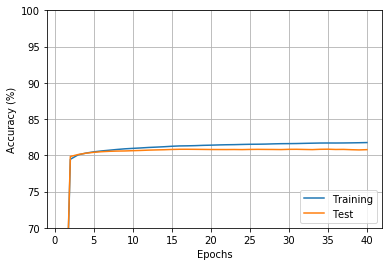

In [74]:
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth


with open(RESULTS_PATH + MODEL_NAME +  "_accuracy.pkl", 'wb') as output:
    pickle.dump(history.history, output, pickle.HIGHEST_PROTOCOL)

# list all data in history
print(history.history.keys())
x = np.asarray(range(1,epochs + 1))
# summarize history for accuracy
plt.figure()
plt.plot(x, smooth([y*100 for y in history.history['acc']],2))
# plt.plot(x, [y*100 for y in history_history['val_acc']])
plt.plot(x, smooth([y*100 for y in history.history['val_acc']],2))
plt.ylabel('Accuracy (%)')
plt.xlabel('Epochs')
plt.ylim(70,100) ###########################
plt.legend(['Training', 'Test'], loc='lower right')
plt.grid()
plt.savefig(RESULTS_PATH + MODEL_NAME +  " accuracy history", bbox_inches='tight')
plt.show()

# Final evaluation of the model
## Evaluate accuracy over the test set

In [75]:
model.load_weights(MODELS_PATH + MODEL_NAME + '_acc.hdf5')

In [76]:
test_scores = model.evaluate(x_test, y_test_vector, batch_size=val_batch_size, verbose=1)
    
    
print("Accuracy: %.2f%%" % (test_scores[1]*100))

171990/171990 [==============================] - 1s 8us/step
Accuracy: 80.89%


In [77]:
y_test_prediction = model.predict_classes(x_test, batch_size=val_batch_size, verbose=1)

171990/171990 [==============================] - 2s 9us/step


In [78]:
y_training_prediction = model.predict_classes(x_training, batch_size=val_batch_size, verbose=1)

687958/687958 [==============================] - 5s 8us/step


## Test if by learning (asn1, asn2) -> p2c then (asn2, asn1) -> c2p and vice versa

In [79]:
p2c = 2
c2p = 1

p2c_training = np.asarray([np.asarray(x_training[i]) for i in range(len(x_training)) if y_training[i] == p2c])
p2c_training_oposite = np.asarray([np.asarray([pair[1], pair[0]]) for pair in p2c_training])

p2c_training_label_vector = to_categorical([p2c]*len(p2c_training), num_classes)
p2c_training_oposite_label_vector = to_categorical([c2p]*len(p2c_training_oposite), num_classes)

print(p2c_training.shape, p2c_training_oposite.shape, p2c_training_oposite_label_vector.shape)

(96404, 2) (96404, 2) (96404, 3)


In [80]:
p2c_training_scores = model.evaluate(p2c_training, p2c_training_label_vector, verbose=1)
print("Accuracy: %.2f%%" % (p2c_training_scores[1]*100))

p2c_training_oposite_scores = model.evaluate(p2c_training_oposite, p2c_training_oposite_label_vector, verbose=1)
print("Accuracy: %.2f%%" % (p2c_training_oposite_scores[1]*100))

96404/96404 [==============================] - 17s 175us/step
Accuracy: 45.22%
96404/96404 [==============================] - 17s 177us/step
Accuracy: 46.86%


## Test if by learning (asn1, asn2) -> p2p then (asn2, asn1) -> p2p and vice versa

In [81]:
p2p = 0

p2p_training = np.asarray([np.asarray(x_training[i]) for i in range(len(x_training)) if y_training[i] == p2p])
p2p_training_oposite = np.asarray([np.asarray([pair[1], pair[0]]) for pair in p2p_training])

p2p_training_label_vector = to_categorical([p2p]*len(p2p_training), num_classes)
p2p_training_oposite_label_vector = to_categorical([p2p]*len(p2p_training_oposite), num_classes)

In [82]:
p2p_training_scores = model.evaluate(p2p_training, p2p_training_label_vector, verbose=1)
print("Accuracy: %.2f%%" % (p2p_training_scores[1]*100))

p2p_training_oposite_scores = model.evaluate(p2p_training_oposite, p2p_training_oposite_label_vector, verbose=1)
print("Accuracy: %.2f%%" % (p2p_training_oposite_scores[1]*100))

495228/495228 [==============================] - 86s 173us/step
Accuracy: 95.45%
495228/495228 [==============================] - 84s 169us/step
Accuracy: 95.37%


## Plot and save a confusion matrix for results over the test set

### Define a function

In [83]:
%matplotlib inline

import matplotlib
import pylab as pl
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          fname='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
        plt.imshow([[100*j for j in i] for i in cm], interpolation='nearest', cmap=cmap)
        cbar = plt.colorbar()
        cbar.ax.set_yticklabels(['0%','20%','40%','60%','80%','100%'])
    else:
        print('Confusion matrix, without normalization')
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.1f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, format(cm[i, j]*100, fmt) + '%',
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")    
        
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig(fname, bbox_inches='tight')

Confusion matrix, without normalization
Normalized confusion matrix


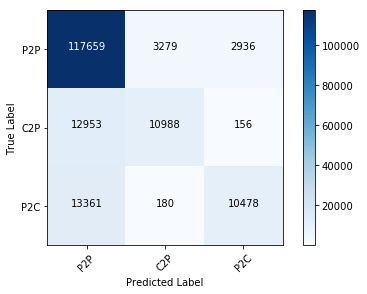

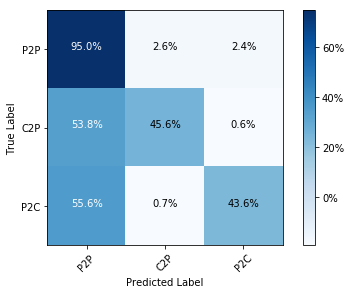

In [84]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_test_prediction)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization',
                      fname=RESULTS_PATH + MODEL_NAME + "_" + 'Confusion_matrix_without_normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized Confusion Msatrix',
                      fname=RESULTS_PATH +MODEL_NAME + "_" + 'Normalized_confusion_matrix')

plt.show()

## Plot cm for training set

Confusion matrix, without normalization
Normalized confusion matrix


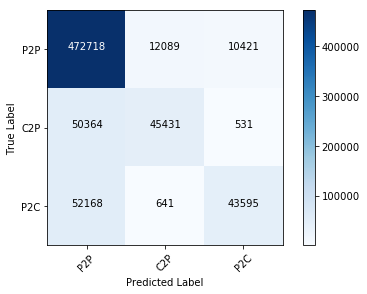

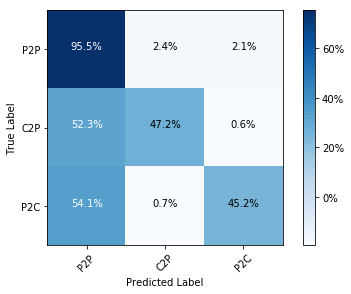

In [85]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_training, y_training_prediction)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization',
                      fname=RESULTS_PATH + MODEL_NAME + "_" + 'training_Confusion_matrix_without_normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized Confusion Matrix',
                      fname=RESULTS_PATH +MODEL_NAME + "_" + 'training_Normalized_confusion_matrix')

plt.show()

# Export the model to a file

In [86]:
model_json = model.to_json()
with open(MODELS_PATH + MODEL_NAME + '.json', "w") as json_file:
    json_file.write(model_json)
model.save_weights(MODELS_PATH + MODEL_NAME + '.h5')
print("Save Model")

Save Model


# Export results to a csv file (with original ASNs)
## Define functions

In [87]:
def dataset_idx2asn(dataset, indexes=None):
    dataset_asn = []
    if indexes is not None:
        dataset = np.take(dataset, indexes, axis=0)

    for i, route in enumerate(dataset):
        route_asn = []
        for idx in route:
            route_asn.append(idx2asn(idx))
        dataset_asn.append(route_asn) 
    return dataset_asn

def dataset_idx2asn_labels(dataset, labels, class_names=class_names, indexes=None):
    dataset_asn = []
    if indexes is not None:
        dataset = np.take(dataset, indexes, axis=0)
        labels = np.take(labels, indexes, axis=0)
    
    for i, route in enumerate(dataset):
        route_asn = []
        for idx in route:
            route_asn.append(idx2asn(idx))
        route_asn.append(class_names[labels[i]])
        dataset_asn.append(route_asn) 
    return dataset_asn


def dataset_idx2asn_labels_predictions(dataset, labels, predictions, class_names=class_names, indexes=None):
    dataset_asn = []
    if indexes is not None:
        dataset = np.take(dataset, indexes, axis=0)
        labels = np.take(labels, indexes, axis=0)
        predictions = np.take(predictions, indexes, axis=0)
    
    for i, route in enumerate(dataset):
        route_asn = []
        for idx in route:
            route_asn.append(idx2asn(idx))
        route_asn.append(class_names[labels[i]])
        route_asn.append(class_names[predictions[i]])
        dataset_asn.append(route_asn) 
    return dataset_asn

def dataset_idx2asn_labels_predictions_prob(dataset, labels, predictions, prob, class_names=class_names, indexes=None):
    dataset_asn = []
    if indexes is not None:
        dataset = np.take(dataset, indexes, axis=0)
        labels = np.take(labels, indexes, axis=0)
        predictions = np.take(predictions, indexes, axis=0)
        prob = np.take(prob, indexes, axis=0)
    
    for i, route in enumerate(dataset):
        route_asn = []
        for idx in route:
            route_asn.append(idx2asn(idx))
        route_asn.append(class_names[labels[i]])
        route_asn.append(class_names[predictions[i]])
        for p in prob[i]:
            route_asn.append(round(p,4))
        
        dataset_asn.append(route_asn) 
    return dataset_asn

import csv
def export_csv(dataset, csv_name, header_type='with_gt'):
    header_types = {
        'reg': ["AS1", "AS2", "Label", "Prediction", "P2P_Prob", "C2P_Prob", "P2C_Prob"],
        'with_gt': ["AS1", "AS2", "Label", 'GT', "Prediction", "P2P_Prob", "C2P_Prob", "P2C_Prob"]
    }
    
    with open(csv_name + '.csv', 'w') as csv_file:
        csv_writer = csv.writer(csv_file)
        if header_type is not None:
            csv_writer.writerow(header_types[header_type])
        for row in dataset:
            csv_writer.writerow(row)

## Load a relevant dataset {all, misclassified, decided, undecided} and get model predictions

In [88]:
y_test_prob = model.predict_proba(x_test, batch_size=val_batch_size, verbose=1)
# y_training_prob = model.predict_proba(x_training, batch_size=val_batch_size, verbose=1)

171990/171990 [==============================] - 1s 8us/step


In [89]:
# # Create test misclassified dataset
x_test_misclassified = np.asarray([route for i,route in enumerate(x_test) if y_test[i] != y_test_prediction[i]])
y_test_misclassified_prediction = np.asarray([label for i,label in enumerate(y_test_prediction) if y_test[i] != y_test_prediction[i]])
y_test_misclassified = np.asarray([label for i,label in enumerate(y_test) if y_test[i] != y_test_prediction[i]])
y_test_misclassified_prob = np.asarray([prob for i,prob in enumerate(y_test_prob) if y_test[i] != y_test_prediction[i]])

print(len(x_test_misclassified), len(y_test_misclassified_prediction), len(y_test_misclassified))
print(y_test_misclassified_prob.shape)

32865 32865 32865
(32865, 3)


In [90]:
dataset_test_misclassified = dataset_idx2asn_labels_predictions_prob(x_test_misclassified, y_test_misclassified,
                                        y_test_misclassified_prediction, y_test_misclassified_prob)
export_csv(dataset_test_misclassified, RESULTS_PATH + MODEL_NAME + "_test_misclassified")

In [91]:
y_test_misclassified_prob_max = np.array([y_test_misclassified_prob[i][pred] for i, pred in enumerate(y_test_misclassified_prediction)])
print(y_test_misclassified_prob_max[:10])

[0.94 0.65 0.69 0.67 0.61 0.91 0.68 0.66 0.97 0.68]


In [92]:
indexes = np.array(list(range(len(x_test_misclassified))))
indexes = [x for _, x in sorted(zip(y_test_misclassified_prob_max,indexes), reverse=True)]
print(indexes[:100])
print(y_test_misclassified_prob_max[indexes[0]])

[31785, 19361, 4145, 15133, 28591, 15351, 17368, 5707, 6392, 12956, 20258, 25595, 24878, 2045, 22104, 8033, 17478, 23644, 8998, 23392, 17871, 16853, 18542, 17916, 3200, 23549, 31399, 32506, 30320, 30499, 13002, 17540, 9007, 30506, 27102, 11666, 32298, 10838, 2043, 9647, 8356, 18204, 30068, 12520, 16815, 159, 30773, 5540, 29052, 13744, 1168, 12523, 18043, 487, 12046, 21284, 11380, 29853, 16549, 32498, 22958, 2704, 27756, 14367, 33, 13912, 8541, 25619, 11467, 26941, 20384, 24531, 3922, 16284, 7449, 5555, 24384, 21262, 13170, 28087, 19832, 24529, 25236, 24312, 14619, 32672, 14588, 11841, 9953, 18767, 11174, 26925, 1141, 8095, 23366, 3633, 27206, 933, 1409, 5652]
0.99939215


## Export Results

In [ ]:
dataset_misclassified = dataset_idx2asn_and_labels(x_test_misclassified, y_test_misclassified_prediction)
export_csv(dataset_misclassified, RESULTS_PATH + MODEL_NAME + "_misclassified")